# COMP5318 - Machine Learning and Data Mining: Assignment 1

<div style="text-align: left"> Group 70: 480440172, 430345827  </div>

# Table of contents
1. [Introduction](#introduction)
    1. [Loading and Exploring the data](#load)
    1. [Visualising the data](#viz)
2. [Pre-Processing](#Pre-Processing)
    1. [Normalisation](#norm)
    1. [PCA for dimensionality reduction](#pca)
3. [Classifiers](#Classifiers)
    1. [k-nearest neighbors](#KNN)
    1. [Decision Tree](#dt)
    1. [Bagging](#bg)
    1. [Random Forest](#RF)
    1. [Support Vector Machines](#SVM)
4. [Results and Comparisions](#results)
5. [Outputting Predictions of the Best Classifier](#output)
6. [Hardware and Software Specifications](#specs)

## 1. Introduction <a name="introduction"></a>

The aim of this study is to implement and evaluate the performance of supervised machine learning classifiers to classify greyscale images into a set of given categories. The accuracy and running time of the classifiers with 10-fold cross-validation were compared using Python’s scikit-learn library. The dataset used consists of greyscale images of size 28x28. There are 30,000 training samples and 2,000 labelled testing samples.


### 1.1 Loading and Exploring the data <a name="load"></a>

In [2]:
# Importing required libraries
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import metrics
from sklearn.decomposition import PCA
import h5py, os, graphviz, numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score, StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

In [4]:
# Stores image and label training as data_train and label_train
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
# Prints the dimensions of the two files 30000 dimensions and 784 elements (28x28)
# The shape of an array is the number of elements in each dimension.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [5]:
# Stores image and label testing as data_train and label_train
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# For marking purposes
# Only first 2000 labels are here so we use the first 2000 test data
#data_test = data_test[:2000]
# with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
#     label_test = np.copy(H['labeltest'])
    
# Prints the dimensions of the two files
print(data_test.shape,label_test.shape)

(2000, 784) (2000,)


As we can see from the shape information the data is stored in hdf5 files and includes: 
1. images_training.h5 (30000 samples for training, with 784 features)
2. labels_training.h5
3. images_testing.h5 (5000 samples for testing, with 784 features)
4. labels_testing_2000.h5

### 1.2 Visualising the data <a name="viz"></a>

We can visualise examples of the class labels to give us a better idea of the type of classifications we will do. The following codes the first 20 images with their class labels.

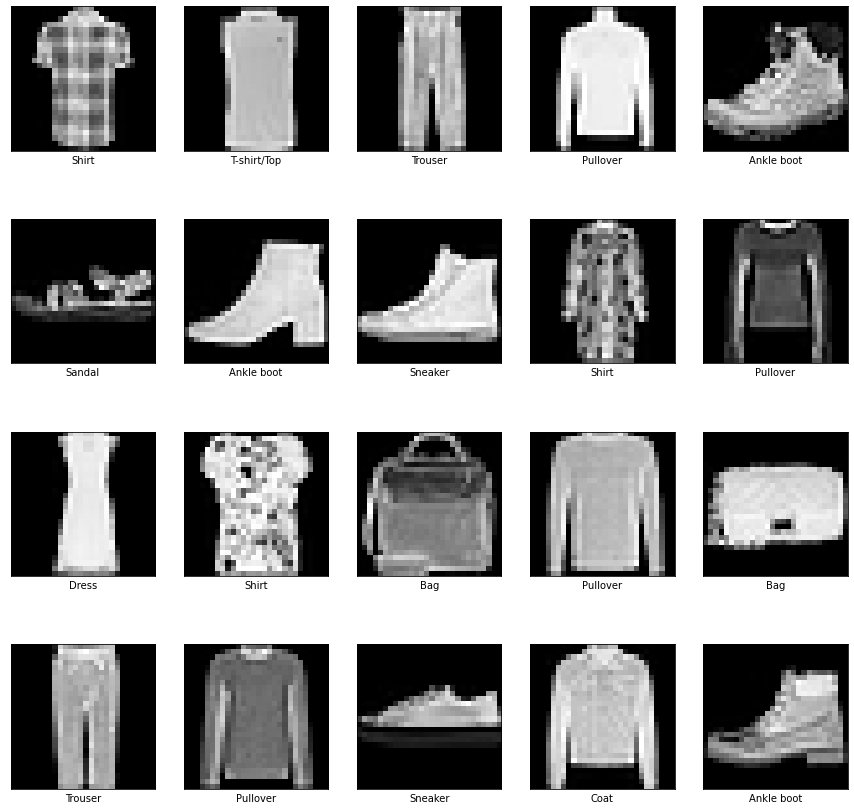

In [6]:
# We can create a list with the class labels
class_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Here we select 20 images to be shown with their label as a visualisation
plt.figure(figsize=(15,15))
data_train_example = data_train.reshape((data_train.shape[0], 28, 28))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(data_train_example[i], cmap=plt.get_cmap('gray'))
    plt.xlabel(class_names[label_train[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## 2. Pre-Processing <a name="Pre-Processing"></a>

### 2.1 Normalisation <a name="norm"></a>

To use certain supervised learning classifiers the data must be normalised. However, as seen in the colour scale, the data did not need to be normalised as all data points range from 0 to 1.

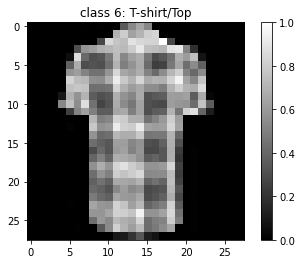

In [7]:
# Extracting one example from the data set and visualising it
data_train_example = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train_example[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.colorbar()
plt.show()

### 2.2 PCA for dimensionality reduction <a name="pca"></a>

In [8]:
# Applying PCA without reducing dimensionality, then compute the min number of dimensions for preserving 95% variance
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

188


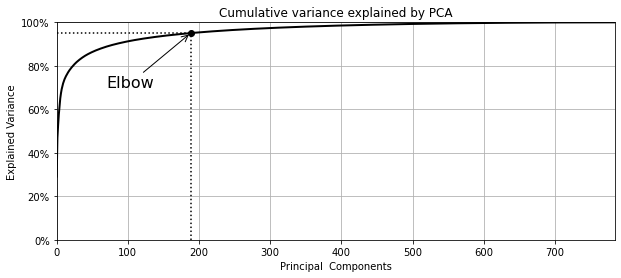

In [9]:
# Plot explained variance vs number of dimensions
plt.figure(figsize=(10,4))
plt.plot(cumsum, linewidth=2, color='black')
plt.axis([0, 784, 0, 1])
plt.xlabel("Principal  Components")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.title("Cumulative variance explained by PCA")
plt.annotate("Elbow", xy=(188, 0.95), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.show()

In [10]:
%%time
# Transforming to keep 95% variance
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(data_train)
test_pca = pca.transform(data_test)

print("Original shape of training data: {}".format(str(data_train.shape)))
print("Reduced shape of training data: {}".format(str(train_pca.shape)))
print("Original shape of testing data: {}".format(str(data_test.shape)))
print("Reduced shape of testing data: {}".format(str(test_pca.shape)))

Original shape of training data: (30000, 784)
Reduced shape of training data: (30000, 188)
Original shape of testing data: (2000, 784)
Reduced shape of testing data: (2000, 188)
Wall time: 1.22 s


As we can see from the output above the features have been reduced from 784 to 188 by keeping 95% of the variance.

In [11]:
%%time
# Comparing PCA data to original using KNN classifier 

# Build using original data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(data_train, label_train)
print("Original data with 3NN accuracy: {:.3f}".format(knn.score(data_test, label_test)))

Original data with 3NN accuracy: 0.840
Wall time: 1min 28s


In [12]:
%%time
# Build using reduced PCA data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_pca, label_train)
print("Reduced data with 3NN accuracy: {:.3f}".format(knn.score(test_pca, label_test)))

Reduced data with 3NN accuracy: 0.839
Wall time: 6.62 s


The original data and reduced PCA data have the same accuracy, however, the PCA data with reduced dimensions runs significantly faster than the original dataset.

## 3. Classifiers <a name="Classifiers"></a>

### 3.1 k-nearest neighbours <a name="KNN"></a>

To fine tune the parameters we will use the Grid Search method. GridSearchCV tries all the combinations of the values passed as parameters, creates a model and evaluates it using the validations sets in 10-fold cross-validation. For the k-nearest neighbours we will test with k = [1, 3, 5, 7, 9,  11] nearest neighbours using the p parameter as 1 (Manhattan distance) and 2 (Euclidean distance).

#### Grid Search on KNN

In [96]:
# Grid Search method with KNN
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
              'p': [1, 2]}

print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid, cv=10,
                           return_train_score=True,
                           n_jobs = -1,
                           verbose = 1)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

# Printing the results of the grid search
print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'n_neighbors': [1, 3, 5, 7, 9, 11], 'p': [1, 2]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 87.3min finished


Test set score: 0.84
Best parameters: {'n_neighbors': 7, 'p': 1}
Best cross-validation score: 0.86
Best estimator:
KNeighborsClassifier(n_neighbors=7, p=1)


#### Evaluate the best parameters from GridSearch on test data

In [6]:
%%time
# Train KNN classifier based on the best parameters
knn = KNeighborsClassifier(p=1, n_neighbors=7)
knn.fit(train_pca, label_train)
pred = knn.predict(test_pca)

# Calculate the accuracy on the test set
knn_acc = accuracy_score(label_test, pred)
# Print the accuracy on the test set
print("Accuracy of KNeighborsClassifier(n_neighbours=7, p=1) on test set: {:.3f}".format(knn_acc))

Accuracy of KNeighborsClassifier(n_neighbours=7, p=1) on test set: 0.841
Wall time: 17.4 s


#### Performance Results of KNN

Performance Scores:
              precision    recall  f1-score   support

           0      0.782     0.839     0.809       192
           1      1.000     0.984     0.992       184
           2      0.710     0.762     0.735       206
           3      0.860     0.831     0.845       207
           4      0.775     0.718     0.745       220
           5      0.994     0.821     0.899       190
           6      0.605     0.621     0.613       190
           7      0.854     0.943     0.896       192
           8      0.973     0.938     0.955       227
           9      0.898     0.958     0.927       192

    accuracy                          0.840      2000
   macro avg      0.845     0.841     0.842      2000
weighted avg      0.845     0.841     0.841      2000



<Figure size 432x288 with 0 Axes>

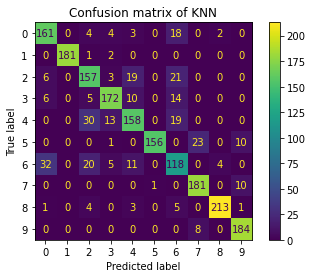

In [16]:
# Print the accuracy, precision, recall and F1 score
print("Performance Scores:")
print(metrics.classification_report(label_test, pred, digits = 3))

# Display the confusion matrix plot
plt.figure()
cm_plot = plot_confusion_matrix(knn, test_pca, label_test)
cm_plot.ax_.set_title("Confusion matrix of KNN")
plt.show()

### 3.2 Decision Tree <a name="dt"></a>

Decision Trees build classification models in the form of a tree structure where it splits the data into smaller subsets, until a class leaf node is reached. The purity is calculated for each node and can help provide the basis for which node to choose. Here we will follow the same grid search method using different max depths for pre-pruning and different criterion. 

#### Grid Search on DT

In [127]:
# Grid Search method with DT
param_grid = {'criterion':['gini','entropy'],'max_depth':[1,3,10,15]}
print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(DecisionTreeClassifier(), 
                           param_grid, cv=10, 
                           return_train_score=True, 
                           n_jobs = -1, 
                           verbose = 1)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 10, 15]}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished


Test set score: 0.77
Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Best cross-validation score: 0.77
Best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=10)


#### Evaluate the best parameters from GridSearch on test data

In [7]:
%%time
# Train DT classifier based on the best parameters
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=10,
                              splitter='best')

tree.fit(train_pca, label_train)
pred = tree.predict(test_pca)

# Calculate and print the accuracy on the testing set
dt_acc = accuracy_score(label_test, pred)
print("Accuracy of DT (split criteria=entropy, max depth=10) on test set: {:.3f}".format(dt_acc))

Accuracy of DT (split criteria=entropy, max depth=10) on test set: 0.776
Wall time: 24.7 s


#### Performance Results of DT

Performance Scores:
              precision    recall  f1-score   support

           0      0.697     0.719     0.708       192
           1      0.937     0.962     0.949       184
           2      0.690     0.660     0.675       206
           3      0.759     0.715     0.736       207
           4      0.635     0.718     0.674       220
           5      0.872     0.821     0.846       190
           6      0.486     0.458     0.472       190
           7      0.820     0.880     0.849       192
           8      0.898     0.855     0.876       227
           9      0.917     0.917     0.917       192

    accuracy                          0.769      2000
   macro avg      0.771     0.770     0.770      2000
weighted avg      0.770     0.769     0.769      2000



<Figure size 432x288 with 0 Axes>

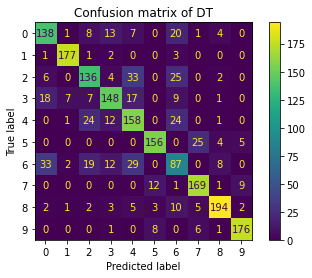

In [18]:
# Print the accuracy, precision, recall and F1 score
print("Performance Scores:")
print(metrics.classification_report(label_test, pred, digits=3))

# Display the confusion matrix plot
plt.figure()
cm_plot = plot_confusion_matrix(tree, test_pca, label_test)
cm_plot.ax_.set_title("Confusion matrix of DT")
plt.show()

### 3.3 Bagging ensemble of Decision Trees <a name="bg"></a>

We can try using the decision trees as the base classifiers in a bagging ensemble.

#### Grid Search on DT

In [ ]:
# Grid Search method with bagging
param_grid = {'n_estimators':[10,50,100],
             'max_samples' : [0.1, 0.5, 1]}

print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(BaggingClassifier(), 
                           param_grid, cv=10, 
                           return_train_score=True, 
                           n_jobs = -1, 
                           verbose = 1)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'n_estimators': [10, 50, 100], 'max_samples': [0.1, 0.5, 1]}
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#### Evaluate the best parameters from GridSearch on test data

In [8]:
%%time

# Training the bagging classifier on the best parameters
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=10, splitter='best'), 
    bootstrap=True,
    max_samples=0.5,
    random_state=42)

bag_clf.fit(train_pca, label_train)
pred = bag_clf.predict(test_pca)

# Calculate and print the accuracy on the testing set
bag_dt_acc = accuracy_score(label_test, pred)
print("Accuracy of Bagging ensemble of DT on test set: {:.3f}".format(bag_dt_acc))

Accuracy of Bagging ensemble of DT on test set: 0.818
Wall time: 2min 26s


#### Peformance Results of Bagging

Performance Scores:
              precision    recall  f1-score   support

           0      0.759     0.771     0.765       192
           1      0.962     0.973     0.968       184
           2      0.695     0.752     0.723       206
           3      0.838     0.797     0.817       207
           4      0.685     0.723     0.704       220
           5      0.885     0.889     0.887       190
           6      0.611     0.505     0.553       190
           7      0.909     0.885     0.897       192
           8      0.902     0.930     0.915       227
           9      0.924     0.953     0.938       192

    accuracy                          0.818      2000
   macro avg      0.817     0.818     0.817      2000
weighted avg      0.816     0.818     0.816      2000



<Figure size 432x288 with 0 Axes>

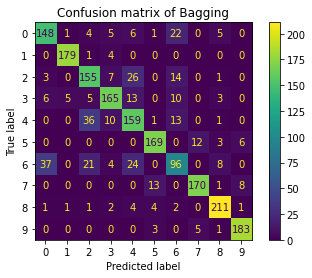

In [20]:
# Print the accuracy, precision, recall and F1 score
print("Performance Scores:")
print(metrics.classification_report(label_test, pred, digits=3))

# Display the confusion matrix plot
plt.figure()
cm_plot = plot_confusion_matrix(bag_clf, test_pca, label_test)
cm_plot.ax_.set_title("Confusion matrix of Bagging")
plt.show()

### 3.4 Random Forest <a name="RF"></a>

#### Grid Search on RF

In [77]:
# Grid Search method with RF
param_grid = {    
    'bootstrap': [True],
    'max_depth': [8, 10, 14, 20],
    'n_estimators': [50, 75, 100, 400]}

print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, return_train_score=True, n_jobs = -1, verbose = 2)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

Parameter grid:
{'bootstrap': [True], 'max_depth': [8, 10, 14, 20], 'n_estimators': [50, 75, 100, 400]}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 25.3min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [8, 10, 14, 20],
                         'n_estimators': [50, 75, 100, 400]},
             return_train_score=True, verbose=2)

In [78]:
print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.85
Best parameters: {'bootstrap': True, 'max_depth': 20, 'n_estimators': 400}
Best cross-validation score: 0.86
Best estimator:
RandomForestClassifier(max_depth=20, n_estimators=400)


Since max_depth = 20 and n_estimators = 400 were the best we can do another grid search with increased values

In [20]:
# Grid Search method with RF
param_grid = {    
    'bootstrap': [True],
    'max_depth': [20, 25, 30],
    'n_estimators': [450, 750, 1000]}

print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, return_train_score=True, n_jobs = -1, verbose = 2)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'bootstrap': [True], 'max_depth': [20, 25, 30], 'n_estimators': [450, 750, 1000]}
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 74.5min finished


Test set score: 0.85
Best parameters: {'bootstrap': True, 'max_depth': 25, 'n_estimators': 1000}
Best cross-validation score: 0.87
Best estimator:
RandomForestClassifier(max_depth=25, n_estimators=1000)


#### Evaluate the best parameters from GridSearch on test data

In [9]:
%%time
# Fitting the classifier on the testing data
rf = RandomForestClassifier(max_depth = 25, 
                            n_estimators=1000, 
                            criterion='entropy', 
                            random_state=42, 
                            n_jobs = -1)

rf.fit(train_pca, label_train)
pred = rf.predict(test_pca)

# Calculate and print the accuracy on the testing set
rf_acc = accuracy_score(label_test, pred)
print("Accuracy of RF on test set: {:.3f}".format(rf_acc))

Accuracy of RF on test set: 0.851
Wall time: 12min 6s


#### Peformance Results of RF

Performance Scores:
              precision    recall  f1-score   support

           0      0.763     0.854     0.806       192
           1      1.000     0.978     0.989       184
           2      0.777     0.796     0.787       206
           3      0.834     0.850     0.842       207
           4      0.776     0.755     0.765       220
           5      0.910     0.900     0.905       190
           6      0.684     0.547     0.608       190
           7      0.921     0.911     0.916       192
           8      0.907     0.947     0.927       227
           9      0.901     0.948     0.924       192

    accuracy                          0.849      2000
   macro avg      0.847     0.849     0.847      2000
weighted avg      0.846     0.849     0.846      2000



<Figure size 432x288 with 0 Axes>

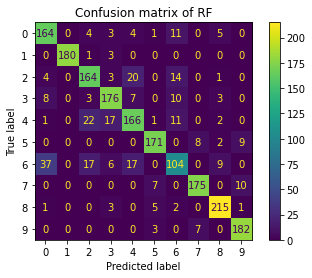

In [26]:
# Print the accuracy, precision, recall and F1 score
print("Performance Scores:")
print(metrics.classification_report(label_test, pred, digits=3))

# Display the confusion matrix plot
plt.figure()
cm_plot = plot_confusion_matrix(rf, test_pca, label_test)
cm_plot.ax_.set_title("Confusion matrix of RF")
plt.show()

### 3.5 Support Vector Machines <a name="SVM"></a>

#### Testing different kernal accuracies

In [54]:
#linear SVM
lin_svm = SVC(kernel="linear")
lin_svm.fit(train_pca, label_train)
pred = lin_svm.predict(test_pca)
print("Linear SVM - accuracy on test set: {:.3f}".format(accuracy_score(label_test, pred)))

# SVM with polynomial kernel
poly_svm = SVC(kernel="poly", degree=2) #polynomial kernel with degree 2
poly_svm.fit(train_pca, label_train)
pred = poly_svm.predict(test_pca)
print("SVM with polynomial kernel - accuracy on test set: {:.3f}".format(accuracy_score(label_test, pred)))

# SVM with RBF kernel
rbf_svm = SVC(kernel="rbf", gamma="auto")
rbf_svm.fit(train_pca, label_train)
pred = rbf_svm.predict(test_pca)
print("SVM with RBF kernel - accuracy on test set: {:.3f}".format(accuracy_score(label_test, pred)))

Linear SVM - accuracy on test set: 0.84
SVM with polynomial kernel - accuracy on test set: 0.856
SVM with RBF kernel - accuracy on test set: 0.863


SVM with RBF kernel has highest accuracy of 0.862. So we will do grid search with cross-validation to the best C and gamma parameters

#### Grid Search on SVM

In [4]:
# Grid Search method with SVM
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100], 
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 
               'kernel': ['rbf']},]

print("Parameter grid:\n{}".format(param_grid))

# Running the 10-fold CV using params in grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=10, return_train_score=True, n_jobs = -1, verbose = 10)

# Fits the grid search model to the training data
grid_search.fit(train_pca, label_train)

Parameter grid:
[{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}]
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 121.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 141.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 162.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 178.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 187.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 214.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=10)

In [5]:
print("Test set score: {:.2f}".format(grid_search.score(test_pca, label_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.88
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.89
Best estimator:
SVC(C=10, gamma=0.01)


#### Evaluate the best parameters from GridSearch on test data

In [10]:
%%time
# Testing the SVM model
svm = SVC(kernel="rbf", C=10)
svm.fit(train_pca, label_train)
pred = svm.predict(test_pca)

# Calculate and print the accuracy on the testing set
svm_acc = accuracy_score(label_test, pred)
print("Accuracy of SVM on test set: {:.3f}".format(svm_acc))

Accuracy of SVM on test set: 0.889
Wall time: 1min 4s


#### Peformance Results of SVM

Performance Scores:
              precision    recall  f1-score   support

           0      0.804     0.833     0.818       192
           1      0.995     0.995     0.995       184
           2      0.800     0.816     0.808       206
           3      0.856     0.860     0.858       207
           4      0.854     0.827     0.841       220
           5      0.979     0.984     0.982       190
           6      0.715     0.674     0.694       190
           7      0.958     0.953     0.956       192
           8      0.957     0.978     0.967       227
           9      0.969     0.974     0.971       192

    accuracy                          0.889      2000
   macro avg      0.889     0.889     0.889      2000
weighted avg      0.888     0.889     0.888      2000



<Figure size 432x288 with 0 Axes>

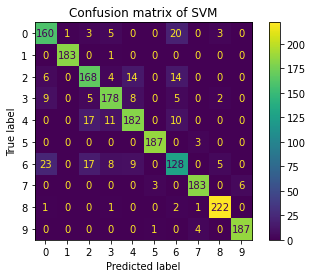

In [28]:
# Print the accuracy, precision, recall and F1 score
print("Performance Scores:")
print(metrics.classification_report(label_test, pred, digits=3))

# Display the confusion matrix plot
plt.figure()
cm_plot = plot_confusion_matrix(svm, test_pca, label_test)
cm_plot.ax_.set_title("Confusion matrix of SVM")
plt.show()

## 4. Results and Comparisions <a name="results"></a>

| Model      | Hyperparameter tuned |Accuracy Training | Accuracy Testing | Precision on testing | Recall on testing | F1 on testing | Training time (seconds)|
| :---------- | :----------- | :----------- | :----------- | :----------- | :----------- | :-----------| :-----------|
| KNN |  k-nearest neigbours and distance measure |86.0% | 84.1%| 84.5%| 84.1%| 84.1%  | 17.4| 
| DT |  Criterion, max_depth, n_estimators |77.0% | 77.6%| 77.0%| 76.9%| 76.9%  | 24.7| 
| Bagging ensemble of DT |  Bootstrap, DT base classifier |84.0% | 81.0%| 81.0%| 81.0%| 80.9%  | 57| 
| RF |  Max_depth, n_estimators |87.0% | 85.1%| 84.6%| 84.9%| 84.6%  | 726| 
| SVM |  Keneral, C, gamma |89.0% | 88.9%| 88.8%| 88.9%| 88.8% | 64| 


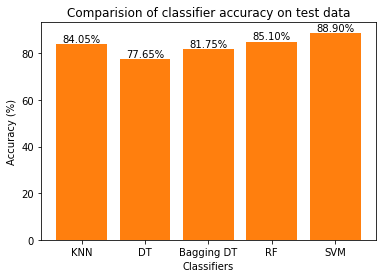

In [11]:
classifier = ['KNN','DT','Bagging DT','RF','SVM']
accuracies = 100*np.array([knn_acc, dt_acc, bag_dt_acc, rf_acc, svm_acc])

plt.bar(classifier, accuracies)
plt.title('Comparision of classifier accuracy on test data')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy (%)')
hbars = plt.bar(classifier, accuracies)
plt.bar_label(hbars, fmt='%.2f%%')
plt.show()

## 5. Outputting the Predictions of the Best Classifier <a name="output"></a>

In [12]:
# Getting the predictions of the best classifier i.e. SVM with RBF kernel and C=10
svm = SVC(kernel="rbf", C=10)
svm.fit(train_pca, label_train)

output = svm.predict(test_pca)

In [13]:
# Saving the output to required file
with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)

## 6. Hardware and Software Specifications <a name="specs"></a>

| Hardware      | OS and Software |
| :---------- | :----------- |
| Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz   2.00 GHz 16.0 GB RAM, 64-bit operating system, x64-based processor      | Windows 10, Anaconda Distribution Jupiter Notebooks, Python 2.7.17       |
| Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz   2.59 GHz 8.0 GB RAM, 64-bit operating system, x64-based processor   | Windows 10, Anaconda Distribution Jupiter Notebooks, Python 2.7.17        |